# A direct quantification of the linearization error

In [1]:
%matplotlib widget

In [28]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.integrate
from tqdm.notebook import tqdm
import crank_nicolson_numba.generic as cn
import itertools
# For parallelization
from joblib import Parallel, delayed

### Setting up the various elements for the Nekhoroshev-like diffusion

In [3]:
def D(I, I_star, exponent):
    return np.exp(-2*np.power(I_star/I, exponent))

def normed_D(I, I_star, exponent, c):
    return c * D(I, I_star, exponent)

def normed_D_half(I, I_star, exponent, c):
    return normed_D(I, I_star, exponent, c)/2

def x(I, I_max, I_star, exponent, c):
    return -scipy.integrate.quad(lambda x: 1/np.sqrt(normed_D(x, I_star, exponent, c)), I, I_max)[0]

def nu(I, I_star, exponent, c, scale=1.0):
    I = I * scale
    return (np.sqrt(c) * exponent / I) * np.power(I_star/I, exponent) * np.exp(-np.power(I_star/I, exponent))

def current_peak_time(I_0, I_max, I_star, exponent, c):
    return 2*(np.sqrt(nu(I_0, I_star, exponent, c)**2 * x(I_0, I_max, I_star, exponent, c)**2 + 9) - 3) / nu(I_0, I_star, exponent, c)**2

def current_peak_value(I_0, I_max, I_star, exponent, c):
    return -x(I_0, I_max, I_star, exponent, c)*np.exp(-nu(I_0, I_star, exponent, c)**2*(x(I_0, I_max, I_star, exponent, c) + (np.sqrt(nu(I_0, I_star, exponent, c)**2*x(I_0, I_max, I_star, exponent, c)**2 + 9) - 3)/nu(I_0, I_star, exponent, c))**2/(4*(np.sqrt(nu(I_0, I_star, exponent, c)**2*x(I_0, I_max, I_star, exponent, c)**2 + 9) - 3)))/(4*np.sqrt(np.pi)*((np.sqrt(nu(I_0, I_star, exponent, c)**2*x(I_0, I_max, I_star, exponent, c)**2 + 9) - 3)/nu(I_0, I_star, exponent, c)**2)**(3/2))

def current_point(t, I, I_max, I_star, exponent, c, scale=1.0):
    if t == 0:
        return 0.0
    return -x(I, I_max, I_star, exponent, c) / (t * np.sqrt(2*np.pi*t)) * np.exp(-(x(I, I_max, I_star, exponent, c)+((nu(I, I_star, exponent, c, scale)/2)*t))**2/(2*t))

def current_general(t, I, I_int_min, I_star, exponent, c, scale=1.0):
    return [scipy.integrate.quad(lambda x: current_point(a_t, x, I_star, exponent, c, scale), I_int_min, I)[0] for a_t in t]

## A little test

In [4]:
I_min = 0.0
I_max = 5.0
I_0 = 4.7
I_star = 21.5
kappa = 0.33
exponent = 1 / (2*kappa)

c = 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), I_min, I_max)[0]

In [7]:
print("peak time:", current_peak_time(I_0, I_max, I_star, exponent, c))
print("peak current:", current_peak_value(I_0, I_max, I_star, exponent, c))

peak time: 0.012644096863218062
peak current: 16.273924818627584


In [9]:
dt = current_peak_time(I_0, I_max, I_star, exponent, c)/1000
samples = 10000
I_linspace, dI = np.linspace(I_min, I_max, samples, retstep=True)
sigma = dI * 5
def rho_0(I):
    return np.exp(-0.5 * (I - I_0)**2/sigma**2) / (sigma*np.sqrt(2*np.pi))
engine = cn.cn_generic(I_min, I_max, rho_0(I_linspace), dt, lambda x: normed_D_half(x, I_star, exponent, c), normalize=False)
times, current = engine.current(3000, 1)

<ipython-input-3-abcfc1428db2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(-2*np.power(I_star/I, exponent))


In [10]:
plt.figure()
plt.plot(times, current, label="Numerical integration")
plt.plot(times, [current_point(t, I_0, I_max, I_star, exponent, c) for t in times], label="Analytic estimation")

plt.axvline(current_peak_time(I_0, I_max, I_star, exponent, c), color='grey', alpha=0.5)
plt.axhline(current_peak_value(I_0, I_max, I_star, exponent, c), color='grey', alpha=0.5)

plt.legend()
plt.xlabel("t")
plt.ylabel("Current")

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

Text(0, 0.5, 'Current')

### First fitting example on a single current peak (using both time and module)

In [11]:
def f(x, peak_time, peak_value, I_0, I_max, I_min=0):
    #print(x)
    c = 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), I_min, I_max)[0]
    t = current_peak_time(I_0, I_max, x[0], x[1], c)
    v = current_peak_value(I_0, I_max, x[0], x[1], c)
    e1 = np.absolute(peak_time - t)/peak_time
    e2 = np.absolute(peak_value - v)/peak_value
    #print(np.sqrt(e1**2 + e2**2))
    return np.sqrt(e1**2 + e2**2)

In [12]:
#I_min = 0.0
#I_max = 5.0
#I_0 = 4.8

#I_0=6.4715 
#I_max=6.536

#I_0=2.15 
#I_max=2.408

#I_0=7.052000000000001 
#I_max=7.181000000000002

#I_star = 21.5
#kappa = 0.33
#exponent = 1 / (2*kappa)
#c = 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), I_min, I_max)[0]

In [23]:
dt = current_peak_time(I_0, I_max, I_star, exponent, c)/1000
samples = 50000

I_linspace, dI = np.linspace(I_min, I_max, samples, retstep=True)
sigma = dI * 50

def rho_0(I):
    return np.exp(-0.5 * (I - I_0)**2/sigma**2) / (sigma*np.sqrt(2*np.pi))

engine = cn.cn_generic(I_min, I_max, rho_0(I_linspace), dt, lambda x: normed_D_half(x, I_star, exponent, c), normalize=False)
times, current = engine.current(3000, 1)

#plt.figure()
#plt.plot(times, current)
#plt.axvline(current_peak_time(I_0, I_max, I_star, exponent, c))
#plt.axhline(current_peak_value(I_0, I_max, I_star, exponent, c))

result = scipy.optimize.minimize(f, (I_star, exponent), args=(times[np.argmax(current)], np.max(current), I_0, I_max, I_min))

<ipython-input-3-abcfc1428db2>:2: RuntimeWarning: divide by zero encountered in double_scalars
  return np.exp(-2*np.power(I_star/I, exponent))


In [24]:
plt.figure()
plt.plot(times, current)
plt.axvline(times[np.argmax(current)])
plt.axhline(np.max(current))
plt.axvline(current_peak_time(I_0, I_max, result.x[0], result.x[1], c), color="green")
plt.axhline(current_peak_value(I_0, I_max, result.x[0], result.x[1], c), color="green")

plt.plot(times, [current_point(t, I_0, I_max, I_star, exponent, c) for t in times], label="Analytic estimation")
plt.plot(times, [current_point(t, I_0, I_max, result.x[0], result.x[1], c) for t in times], label="Analytic estimation")

plt.axvline(current_peak_time(I_0, I_max, I_star, exponent, c), color='grey', alpha=0.5)
plt.axhline(current_peak_value(I_0, I_max, I_star, exponent, c), color='grey', alpha=0.5)

print(I_star, 1/exponent/2)
print(result.x[0], 1/result.x[1]/2)
print("--------")
print(times[np.argmax(current)])
print(current_peak_time(I_0, I_max, I_star, exponent, c))
print(current_peak_time(I_0, I_max, result.x[0], result.x[1], c))
print("--------")
print(np.max(current))
print(current_peak_value(I_0, I_max, I_star, exponent, c))
print(current_peak_value(I_0, I_max, result.x[0], result.x[1], c))
print("--------")

result

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

21.5 0.33
15.697794121354432 0.2607418546138018
--------
0.012239485763595084
0.012644096863218062
0.012238649266515246
--------
17.486265687390503
16.273924818627584
17.484882636134103
--------


      fun: 0.00010453092576911125
 hess_inv: array([[ 3.56636904, -0.36948029],
       [-0.36948029,  0.03827873]])
      jac: array([0.22819643, 2.2049504 ])
  message: 'Desired error not necessarily achieved due to precision loss.'
     nfev: 603
      nit: 118
     njev: 197
   status: 2
  success: False
        x: array([15.69779412,  1.91760544])

In [27]:
plt.figure()
data = engine.get_data_with_x()
plt.plot(data[0], data[1])
engine.reset()
data = engine.get_data_with_x()
plt.plot(data[0], data[1])
engine.iterate(1)
data = engine.get_data_with_x()
plt.plot(data[0], data[1])


Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

## Let's try to go with the big guns

In [32]:
I_min = 0.0
I_star = 21.5
kappa = 0.33
exponent = 1 / (2*kappa)
cn_samples = 10000
c = 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), I_min, I_max)[0]

In [55]:
def f(x, peak_time, peak_value, I_0, I_max, I_min=0):
    #print(x)
    c = 1/scipy.integrate.quad(lambda x: D(x, I_star, exponent), I_min, I_max)[0]
    t = current_peak_time(I_0, I_max, x[0], x[1], c)
    v = current_peak_value(I_0, I_max, x[0], x[1], c)
    e1 = np.absolute(peak_time - t)/peak_time
    e2 = np.absolute(peak_value - v)/peak_value
    #print(np.sqrt(e1**2 + e2**2))
    return np.sqrt(e1**2 + e2**2)

def compute_fittings(nI_0, nI_max):
    I_max = nI_max * I_star
    I_0 = nI_0 * I_star

    I_linspace, dI = np.linspace(I_min, I_max, cn_samples, retstep=True)
    sigma = dI * 15
    def rho_0(I):
        return np.exp(-0.5 * (I - I_0)**2/sigma**2) / (sigma*np.sqrt(2*np.pi))
    dt = current_peak_time(I_0, I_max, I_star, exponent, c)/1000
    engine = cn.cn_generic(I_min, I_max, rho_0(I_linspace), dt, lambda x: normed_D_half(x, I_star, exponent, c), normalize=False)
    times, current = engine.current(2000, 1)

    num_current_peak = np.max(current)
    num_current_time = times[np.argmax(current)]

    ana_current_peak = current_peak_value(I_0, I_max, I_star, exponent, c)
    ana_current_time = current_peak_time(I_0, I_max, I_star, exponent, c)
    result = scipy.optimize.minimize(f, (I_star, exponent), args=(num_current_time, num_current_peak, I_0, I_max, I_min))
    fitted_I_star = result.x[0]
    fitted_kappa = 1/result.x[1]/2
    
    return num_current_peak, num_current_time, ana_current_peak, ana_current_time, fitted_I_star, fitted_kappa

In [59]:
min_nI = 0.1
max_nI = 0.5
nI_samples = 41
nI_samples_list, d_nI = np.linspace(min_nI, max_nI, nI_samples, retstep=True)

In [60]:
index_list = list(itertools.combinations(range(nI_samples), 2))

In [ ]:
data = Parallel(n_jobs=4)(delayed(compute_fittings)(nI_samples_list[i[0]], nI_samples_list[i[1]]) for i in index_list)

In [52]:
num_current_peak = np.empty((nI_samples, nI_samples)) * np.nan
num_current_time = np.empty((nI_samples, nI_samples)) * np.nan

ana_current_peak = np.empty((nI_samples, nI_samples)) * np.nan
ana_current_time = np.empty((nI_samples, nI_samples)) * np.nan

fitted_I_star = np.empty((nI_samples, nI_samples)) * np.nan
fitted_kappa = np.empty((nI_samples, nI_samples)) * np.nan

for i, j in enumerate(index_list):
    num_current_peak[j[1], j[0]], num_current_time[j[1], j[0]], ana_current_peak[j[1], j[0]], ana_current_time[j[1], j[0]], fitted_I_star[j[1], j[0]], fitted_kappa[j[1], j[0]] = data[i]

In [54]:
fitted_kappa

array([[            nan,             nan,             nan,
                    nan,             nan],
       [ 3.50342276e-01,             nan,             nan,
                    nan,             nan],
       [ 7.00116346e-04,  2.69392112e-01,             nan,
                    nan,             nan],
       [ 3.32331012e-01,  2.59891791e-01, -2.39244723e-01,
                    nan,             nan],
       [ 2.84946675e-01, -1.79604717e+01, -1.27328299e-05,
        -8.29678414e-06,             nan]])

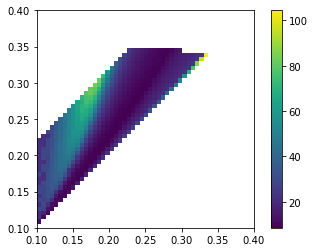

In [141]:
plt.figure()
plt.imshow(fitted_I_star, origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
plt.colorbar()

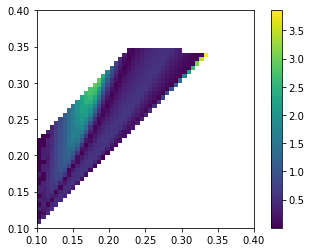

In [139]:
plt.figure()
plt.imshow(np.absolute(fitted_I_star-I_star)/I_star, origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
plt.colorbar()

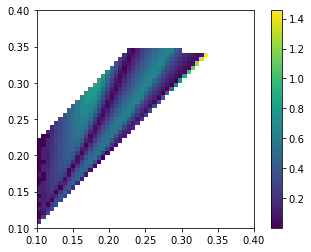

In [140]:
plt.figure()
plt.imshow(np.absolute(fitted_kappa-kappa)/kappa, origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
plt.colorbar()

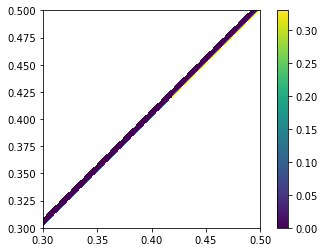

In [104]:
plt.figure()
plt.imshow(fitted_kappa, origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
plt.colorbar()

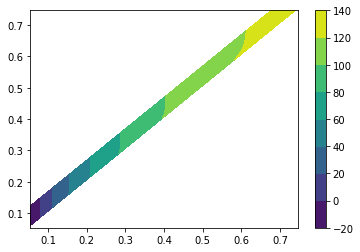

In [71]:
plt.figure()
plt.contourf(np.log(num_current_peak), origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
#plt.imshow(np.absolute(num_current_peak-ana_current_peak)/num_current_peak)
plt.colorbar()

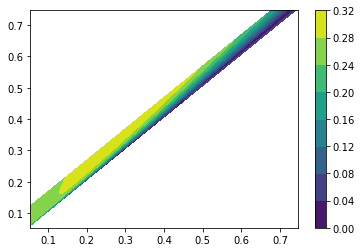

In [72]:
plt.figure()
plt.contourf(np.absolute(num_current_peak-ana_current_peak)/num_current_peak, origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
#plt.imshow(np.absolute(num_current_peak-ana_current_peak)/num_current_peak)
plt.colorbar()

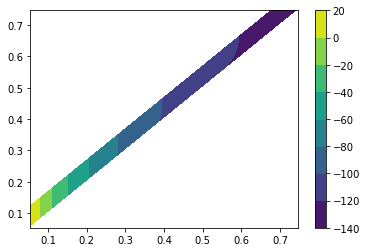

In [73]:
plt.figure()
plt.contourf(np.log(num_current_time), origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
#plt.imshow(np.absolute(num_current_peak-ana_current_peak)/num_current_peak)
plt.colorbar()

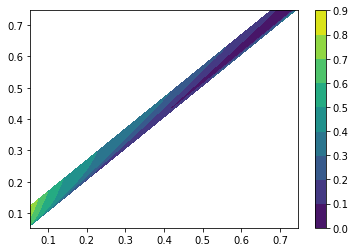

In [74]:
plt.figure()
plt.contourf(np.absolute(num_current_time-ana_current_time)/num_current_time, origin="lower", extent=[min_nI, max_nI, min_nI, max_nI])
#plt.imshow(np.absolute(num_current_peak-ana_current_peak)/num_current_peak)
plt.colorbar()